# Genetic Algorithm

Author: Caitlin-Dawn Sangcap

This was my attempt at recreating Costa's work taking a genetic algorithm approach to the League of Legends team composition based on 3 strategies:

    1. Hard Engage
    2. Team Fight
    3. Poke
    
Due to missining data and not being able to find the source of that data there were certain features that I was not able to code for. Some of those features were:
   
   - A specific Champion's winrate
   - A specific Champion's recommended lane position
   - A specific Champion's counter
   - Ensuring that each team does not have any repeating champions
   - Excluding a specific set of champions from the pool selection
   
Bugs remaining:

    For some reason, there is a bug in where if I try to find the fitness value for the Poke strategy, it always returns 0. I don't understand why but it is another thing I plan to edit in the future.

## How to change the settings for the program:

    Step 1) In the 'Generating the size of the population' section, change the value on for 'sol_per_pop' to the desired size of the population.
    Step 2) In the 'Passing the teams to the genetic algorithm' section, change the number of generations and the mutation rate to the desired values.
    Step 3) In the 'Saving the results in a .csv file for later use' section, change the name of the .csv file to whatever name you desire to record the fitness value results of the current iteration.

In [59]:
import numpy as np
from random import choice
import pandas as pd
import random
import csv
import matplotlib.pyplot as plt

## Genetic Algorithm functions

Due to not being able to completely replicate the functions and classes from the Costa paper, I resulted to using another coder's genetic algorithm functions and modifying it as needed for my purposes.

In [46]:
#pulled the code from:
# https://github.com/ahmedfgad/GeneticAlgorithmPython/blob/master/Tutorial%20Project/ga.py

#modified function
#will get passed a 2d array containing row index for the champion at that role
def cal_pop_fitness(pop,champ_info,strategy):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    fitness = []
    for row in range(len(pop)):
        temp = 0
        for col in range(len(pop[row])):
            if(strategy == "Hard Engage"):
                temp1 = champ_info.iloc[pop[row][col]]['Attack Damage']+champ_info.iloc[pop[row][col]]['Movement Speed']
                temp += temp1
            elif (strategy == "Team Fight"):
                temp1 = champ_info.iloc[pop[row][col]]['Attack Damage']+champ_info.iloc[pop[row][col]]['Attack Damage per Level']+champ_info.iloc[pop[row][col]]['Attack Speed per Level']
                temp += temp1
            elif (strategy == "Poke"):
                temp1 = champ_info.iloc[pop[row][col]]['Attack Damage']+champ_info.iloc[pop[row][col]]['Attack Range']+champ_info.iloc[pop[row][col]]['Attack Speed per Level']
                temp += temp1
            else:
                print("Invalid Strategy")
        fitness.append(temp)
    return fitness

#added line 39 to line 41
#no change needed here
#fitness = 1d array
def select_mating_pool(pop, fitness, num_parents):
    #make a copy of fitness
    copied_fit = []
    for num in range(len(fitness)):
        copied_fit.append(fitness[num])

    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(copied_fit == np.max(copied_fit))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        copied_fit[max_fitness_idx] = -99999999999
    return parents

#original function
#no change needed here
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)
    #print("Crossover_point: ",crossover_point)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring


def mutation(offspring_crossover,population,mutation_chance):
    random_chance = int(np.random.uniform(0,11,1))
    # Mutation changes a single gene in each offspring randomly.
    
    # to emualate the chance of mutation happening
    if (random_chance <= mutation_chance):
        
        for idx in range(offspring_crossover.shape[0]):
        
            #getting the number of genes to mutate
            mutation_counter = int(np.random.uniform(0,5,1))
            
            if mutation_counter > 0:
                
                #to mutate the number of genes
                mutate = 0
                while mutate < mutation_counter:
                    
                    #does not account for muation in the same position as of now
                    #the index of the gene to change
                    gene_idx = int(np.random.uniform(0,5,1))
            
                    check = 0 
                    random_value = 0
                    while(check == 0):
                        #print("check = ", check)
                        random_value = int(np.random.uniform(0,153,1))
                        #print("random_value = ",random_value)
                        checker = np.argwhere(population == random_value)
                        #print("checker = ", checker)
                        if checker.size == 0:
                            if random_value < 152:
                                check = 1
                        
                    offspring_crossover[idx, gene_idx] = random_value
                    mutate +=1
            
    return offspring_crossover

#new function to handle the fitness value
def fitness_value(fitness_info,strategy):
    # Calculating the fitness value of each solution in the current population.
    fitness_val = 0
    if (strategy == "Hard Engage"):
        fitness_val = (fitness_info/2125)*100
    elif (strategy == "Team Fight"):
        fitness_val = (fitness_info/405)*100
    elif (strategy == "Poke"):
        fitness_val == (fitness_info/3630)*100
    else:
        print("Invaled strategy")
    return fitness_val

## Load in the Champion Information

In [47]:
#getting the champion dataset
champion = pd.read_csv('Champion_Info_Mod.csv', sep=",")
champion.head()

,Unnamed: 0,ID_Num,Name,Attack Damage,Attack Damage per Level,Attack Range,Attack Speed per Level,Health Points,Movement Speed,Difficulty,Lane,Tags
0,0,266,Aatrox,60.00,5.00,175,2.500,580.0,345,4,Top,"['Fighter', 'Tank']"
1,1,103,Ahri,53.04,3.00,550,2.000,526.0,330,5,Mid,"['Mage', 'Assassin']"
2,2,84,Akali,62.40,3.30,125,3.200,575.0,345,7,"Top,Mid",['Assassin']
3,3,12,Alistar,62.00,3.75,125,2.125,600.0,330,7,Support,"['Tank', 'Support']"
4,4,32,Amumu,53.38,3.80,125,2.180,615.0,335,3,Jungle,"['Tank', 'Mage']"


In [48]:
# Inputs of the equation.
# can change this as needed if a champion was already selected.

equation_inputs = [425,425,425,425,425]

# Number of the weights we are looking to optimize.
# going to be the sum of the needed stats of a given champion
num_weights = len(equation_inputs)


## Generating the size of the population

In [54]:
sol_per_pop = 30
# Defining the population size.

pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.

#Creating the initial population.
new_population = np.zeros(shape=(sol_per_pop,num_weights), dtype=int)
#print(new_population)

## Generating the teams

In [55]:
pop_size_real = sol_per_pop*num_weights
trial = np.asarray(random.sample(range(0,152),pop_size_real))

new_population=trial.reshape(sol_per_pop,num_weights)
#print(new_population)

## Passing the teams to the genetic algorithm

In [56]:
records = [["Generation", "Hard Engage","Team Fight","Poke"]]
mutation_rate = 7
num_generations = 1000

#number of parents mating minimum = 2
num_parents_mating = sol_per_pop -1
for generation in range(num_generations):
    gather = []
    gather.append(generation+1)
    for num in range(3):
        #print("Generation: ", generation+1)
        # Measuring the fitness of each chromosome in the population.
        strat = 'No strat'
        if (num == 0):
            strat = "Hard Engage"
            #print(strat)
        elif (num == 1):
            strat = "Team Fight"
            #print(strat)
        elif (num == 2):
            strat = "Poke"
            #print(strat)
        fitness = cal_pop_fitness(new_population,champion,strat)
        #print(strat,fitness)
    
        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, num_parents_mating)
        #print("Parents: ")
        #print(parents)
 
        # Generating next generation using crossover.
        if pop_size[0] == num_parents_mating:
            offspring_crossover = crossover(parents,offspring_size=(1, num_weights))
        else:
            offspring_crossover = crossover(parents,offspring_size=(pop_size[0]-parents.shape[0], num_weights))
        #print("Offspring_crossover:")
        #print(offspring_crossover)
    
        # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover,new_population,mutation_rate)
        #print("offspring_mutation:")
        #print(offspring_mutation)
        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation
    
        #print("new_population:")
        #print(new_population)
    
        # The best result in the current iteration.
        fitness_new = cal_pop_fitness(new_population,champion,strat)
        fit_value = fitness_value(np.max(fitness_new),strat)
        gather.append(fit_value)
        #print(strat, fit_value)
        #print("Best result after crossover and mutation (Hard Engage): ", np.max(HE_fit_new))
    records.append(gather)

In [57]:
#print(records)

[['Generation', 'Hard Engage', 'Team Fight', 'Poke'], [1, 95.76470588235294, 89.67901234567901, 0], [2, 95.76470588235294, 89.9148148148148, 0], [3, 96.04705882352941, 89.9148148148148, 0], [4, 96.04705882352941, 89.9148148148148, 0], [5, 96.04705882352941, 89.9148148148148, 0], [6, 96.04705882352941, 89.9148148148148, 0], [7, 96.04705882352941, 89.9148148148148, 0], [8, 96.04705882352941, 89.9148148148148, 0], [9, 96.04705882352941, 89.9148148148148, 0], [10, 96.04705882352941, 89.9148148148148, 0], [11, 96.04705882352941, 89.9148148148148, 0], [12, 96.04705882352941, 89.9148148148148, 0], [13, 96.04705882352941, 89.9148148148148, 0], [14, 96.04705882352941, 89.9148148148148, 0], [15, 96.04705882352941, 89.9148148148148, 0], [16, 96.04705882352941, 89.9148148148148, 0], [17, 96.04705882352941, 89.9148148148148, 0], [18, 96.04705882352941, 89.9148148148148, 0], [19, 96.04705882352941, 89.9148148148148, 0], [20, 96.04705882352941, 89.9148148148148, 0], [21, 96.04705882352941, 89.9148148

## Saving the results in a .csv file for later use

In [58]:
with open('P_30_MR_7_G_1000.csv', 'w', newline='') as file:
    writer = csv.writer(file, quoting=csv.QUOTE_NONNUMERIC, delimiter=',')
    writer.writerows(records)

# Displaying the results

Due to my unfamiliarity in collecting all the data in one go, I had to manually go through the code above, change the needed values to mimic the settings that were used to test the Genetic Algorithm from Costa's work and collect that data bit by bit.

Settings:

    Setting 1: Population = 10, Mutation Rate = 0.3, Generations = 10
    Setting 2: Population = 20, Mutation Rate = 0.5, Generations = 100
    Setting 3: Population = 30, Mutation Rate = 0.7, Generations = 1000
    
The corresponding results are in the labeled .csv files. 

Below are the results.

## Setting 1 Results

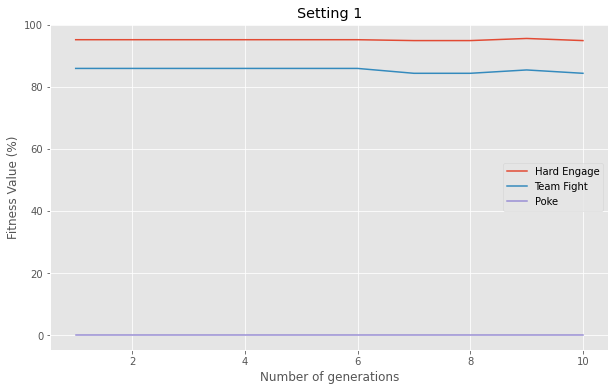

In [60]:
results_s1 = pd.read_csv('P_10_MR_3_G_10.csv', sep=",")
#results_s1.head()

x_axis = results_s1["Generation"]
hard_engage = results_s1["Hard Engage"]
#print(hard_engage)
team_fight = results_s1["Team Fight"]
poke = results_s1["Poke"]

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Setting 1')
plt.plot(x_axis, hard_engage, label='Hard Engage')
plt.plot(x_axis, team_fight, label='Team Fight')
plt.plot(x_axis, poke, label='Poke')
plt.legend()
plt.xlabel('Number of generations')
plt.ylabel('Fitness Value (%)')
plt.show()

## Setting 2 Results

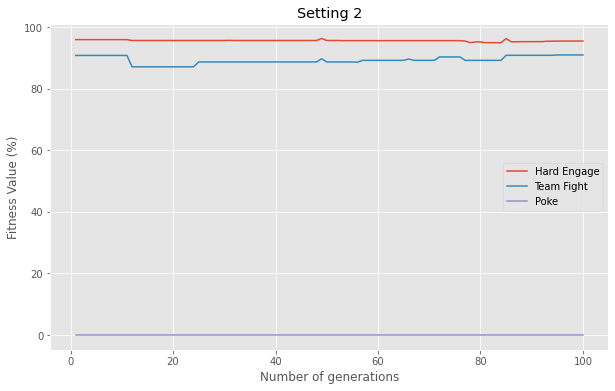

In [61]:
results_s2 = pd.read_csv('P_20_MR_5_G_100.csv', sep=",")
#results_s1.head()

x_axis2 = results_s2["Generation"]
hard_engage2 = results_s2["Hard Engage"]
#print(hard_engage)
team_fight2 = results_s2["Team Fight"]
poke2 = results_s2["Poke"]

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Setting 2')
plt.plot(x_axis2, hard_engage2, label='Hard Engage')
plt.plot(x_axis2, team_fight2, label='Team Fight')
plt.plot(x_axis2, poke2, label='Poke')
plt.legend()
plt.xlabel('Number of generations')
plt.ylabel('Fitness Value (%)')
plt.show()

## Setting 3 Results

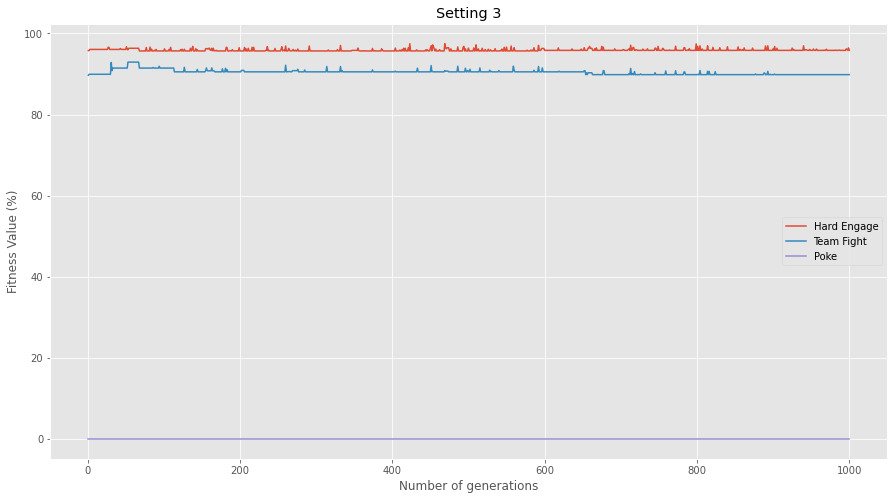

In [62]:
results_s3 = pd.read_csv('P_30_MR_7_G_1000.csv', sep=",")
#results_s1.head()

x_axis3 = results_s3["Generation"]
hard_engage3 = results_s3["Hard Engage"]
#print(hard_engage)
team_fight3 = results_s3["Team Fight"]
poke3 = results_s3["Poke"]

plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 8))
plt.title('Setting 3')
plt.plot(x_axis3, hard_engage3, label='Hard Engage')
plt.plot(x_axis3, team_fight3, label='Team Fight')
plt.plot(x_axis3, poke3, label='Poke')
plt.legend()
plt.xlabel('Number of generations')
plt.ylabel('Fitness Value (%)')
plt.show()

# Future Work

This current form of the genetic algorithm that I had envisioned is far from perfect and still has it's bugs. This is still just another thing to improve on. 

A small list of things I pla to improve on in the future I plan to improve a list of things:

    - use websites to gather the most up to date win rate of specific champions
    - use websites to gather the most up to date champion counters
    - coding to ensure that each team does not have any repeat champions
    - making it useful for any player from novice to professional